# Data Preparation

In [1]:
# import required modules for data preparation tasks
import requests, zipfile, StringIO
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import re

###1. Get the Data for 2014 from zip Files

First, we want to open and combine the zipped data files for each month that have been downloaded according to the process outlined in `01_Data Aquisition.ipynb`.

In [10]:
# reads all predefined months for a year and merge into one data frame
completeData = pd.DataFrame()
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
for m in months:
    z = zipfile.ZipFile('cache/2014%s.zip' % m)
    completeData = completeData.append(pd.read_csv(z.open(z.namelist()[0])))
    print "Downloaded", m

Downloaded 01
Downloaded 02
Downloaded 03
Downloaded 04
Downloaded 05
Downloaded 06
Downloaded 07
Downloaded 08
Downloaded 09
Downloaded 10
Downloaded 11
Downloaded 12


The resulting dataframe `completeData` will be locally stored as csv file.

In [11]:
completeData.to_csv('cache/complete2014Data.csv')

### 2. Combine Data with External Aircraft Data

We also have two tables containing infos about the aircraft and its manufacturer available. Both files will be loaded.

In [12]:
z = zipfile.ZipFile('aircraftData/AircraftInformation.zip')
df_master  = pd.DataFrame.from_csv(z.open('MASTER.txt'))
df_aircrafts  = pd.DataFrame.from_csv(z.open('ACFTREF.txt'))

We can now join these two tables based on their common ID that is saved in the column `MFR MDL CODE` of the master table and in the index of the aircraft table respectively.

In [13]:
master = df_master[['MFR MDL CODE', 'YEAR MFR']].reset_index()
aircrafts = df_aircrafts['MFR'].reset_index()
master.columns = ['TAIL_NUM', 'CODE', 'YEAR']
aircrafts.columns = ['CODE', 'MFR']
joined = pd.merge(master, aircrafts, how='left', on='CODE')
# reset index of complete dataset for delays to prepare merging in next step
completeData.reset_index(inplace=True)

We now join this aircraft information with our delay data and extend the original dataset with the two new features: The year in which the aircraft was built (to determine the age) and the manufacturer.

In [15]:
delayFinal = completeData[['TAIL_NUM','AIRLINE_ID']]
delayFinal.TAIL_NUM = delayFinal.TAIL_NUM.str.strip('N')
delaymfr = pd.merge(delayFinal, joined, how='left', on=['TAIL_NUM'])
completeData['AIRCRAFT_YEAR'] = delaymfr.YEAR
completeData['AIRCRAFT_MFR'] = delaymfr.MFR

Again, we save everything in the csv file.

In [17]:
completeData.to_csv('cache/complete2014Data.csv')

### 3. Combine Data with External Weather Data

*Describe Merging Process with weather data here*

In [18]:
# your code

### 4. Description of the Final Dataset

List features

### REMOVE LATER: Exploratory Analysis

In [2]:
completeData = pd.DataFrame.from_csv('cache/complete2014Data.csv')

/Users/David/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (71,76,96) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [42]:
subset = completeData[[u'MONTH', u'DAY_OF_MONTH',
       u'UNIQUE_CARRIER', u'AIRLINE_ID',
       u'CARRIER', u'ORIGIN', u'DEST', u'CRS_DEP_TIME',
       u'DEP_TIME', u'WEATHER_DELAY', u'NAS_DELAY']]

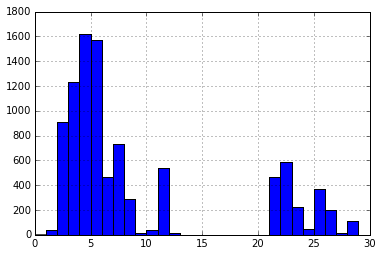

In [46]:
subset[(subset.WEATHER_DELAY > 0) & (subset.ORIGIN == 'JFK')].sort(columns='DAY_OF_MONTH').DAY_OF_MONTH.hist(bins = np.arange(0,30,1))
#subset[(subset.DEP_TIME == 1144) & (subset.CRS_DEP_TIME == 1129)]
#z = zipfile.ZipFile('cache/201411.zip')
#test = pd.read_csv(z.open(z.namelist()[0]))

In [47]:
# percentage of missing aircraft information
sum(completeData.AIRCRAFT_YEAR.isnull())/(1.0*len(completeData.AIRCRAFT_YEAR.isnull()))

0.29173914978101445

In [34]:
years = [int(year) for year in delaymfr.YEAR.str.strip().values if (not year != year and (len(year)==4))]
plt.xlim(1980,2020)
plt.hist(years, bins=np.arange(1950, 2020, 1))